In [1]:
import sys
# If you want to re-run, just modify this to where you put the NS_NFMC fork of the PyMC3 repo.
sys.path.insert(1, '/home/richard/pymc3_dev/')
import arviz as az
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm
from pymc3.theanof import inputvars
import theano
import theano.tensor as tt
import seaborn as sns
import pandas as pd

print(f"Running on PyMC3 v{pm.__version__}")

az.style.use("arviz-darkgrid")

WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'


Running on PyMC3 v3.11.0


In [7]:
n = 4

mu1 = np.ones(n) * (1.0 / 2)
mu2 = -mu1

stdev = 0.1
sigma = np.power(stdev, 2) * np.eye(n)
isigma = np.linalg.inv(sigma)
dsigma = np.linalg.det(sigma)

w1 = 0.3  # one mode with 0.3 of the mass 
w2 = 1 - w1  # the other mode with 0.7 of the mass

def two_gaussians(x):
    log_like1 = (
        -0.5 * n * tt.log(2 * np.pi)
        - 0.5 * tt.log(dsigma)
        - 0.5 * (x - mu1).T.dot(isigma).dot(x - mu1)
    )
    log_like2 = (
        -0.5 * n * tt.log(2 * np.pi)
        - 0.5 * tt.log(dsigma)
        - 0.5 * (x - mu2).T.dot(isigma).dot(x - mu2)
    )
    return pm.math.logsumexp([tt.log(w1) + log_like1, tt.log(w2) + log_like2])

with pm.Model() as model:
    X = pm.Uniform(
        "X",
        shape=n,
        lower=-2.0 * np.ones_like(mu1),
        upper=2.0 * np.ones_like(mu1),
        testval=-1.0 * np.ones_like(mu1),
    )
    #X = pm.Normal('X', mu=0, sigma=1, shape=n)
    
    llk = pm.Potential("llk", two_gaussians(X))
    
    smc_trace = pm.sample_smc(250)
    init_samples = smc_trace.get_values('X')
    print(np.shape(init_samples))
    
with model:
    
    trace = pm.sample_nfmc(2000, init_samples=None, optim_iter=1000, nf_iter=40, chains=1,
                           frac_validate=0.2, alpha=(0.75,0.75), parallel=False,
                           ftol=1.0e-12, NBfirstlayer=True, bw_factor=0.5, k_trunc=0.25, pareto=False,
                           iteration=None)
    az_trace = az.from_pymc3(trace)

Initializing SMC sampler...
Sampling 2 chains in 0 job
/home/richard/pymc3_dev/pymc3/sampling.py:1924: UserWarning: The effect of Potentials on other parameters is ignored during prior predictive sampling. This is likely to lead to invalid or biased predictive samples.
  warnings.warn(
Stage:   0 Beta: 0.011
Stage:   1 Beta: 0.029
Stage:   2 Beta: 0.066
Stage:   3 Beta: 0.138
Stage:   4 Beta: 0.290
Stage:   5 Beta: 0.638
Stage:   6 Beta: 1.000
Stage:   0 Beta: 0.011
Stage:   1 Beta: 0.030
Stage:   2 Beta: 0.069
Stage:   3 Beta: 0.149
Stage:   4 Beta: 0.342
Stage:   5 Beta: 0.753
Stage:   6 Beta: 1.000
Initializing normalizing flow based sampling...
Sampling 1 chain Cores available for optimization: 0


(500, 4)
Fitting the first NF approx to the initial samples ...


Stage:   1, Normalizing Constant Estimate: 1.1216318284609739e-05


RuntimeError: The expanded size of the tensor (0) must match the existing size (2) at non-singleton dimension 1.  Target sizes: [4, 0].  Tensor sizes: [4, 2]

In [43]:
nf_evidence = trace.report.evidence
print(f'NFMC calculated evidence = {nf_evidence[0]}')
weighted_samples = trace.report.weighted_samples[0]
q0_samples = weighted_samples[:2000, ...]
importance_weights = trace.report.importance_weights
q0_weights = importance_weights[0][:2000]
az_summary = az.summary(az_trace)
print(az_summary)

arviz - WARNING - Shape validation failed: input_shape: (1, 500), minimum_shape: (chains=2, draws=4)


NFMC calculated evidence = 0.003833417851500362
       mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_mean  ess_sd  \
X[0] -0.153  0.472  -0.657    0.589      0.021    0.016     510.0   425.0   
X[1] -0.140  0.495  -0.665    0.633      0.022    0.017     497.0   407.0   
X[2] -0.132  0.492  -0.597    0.651      0.022    0.016     515.0   483.0   
X[3] -0.131  0.505  -0.642    0.638      0.022    0.016     546.0   491.0   

      ess_bulk  ess_tail  r_hat  
X[0]     472.0     452.0    NaN  
X[1]     444.0     414.0    NaN  
X[2]     517.0     458.0    NaN  
X[3]     622.0     510.0    NaN  


<Figure size 720x480 with 0 Axes>

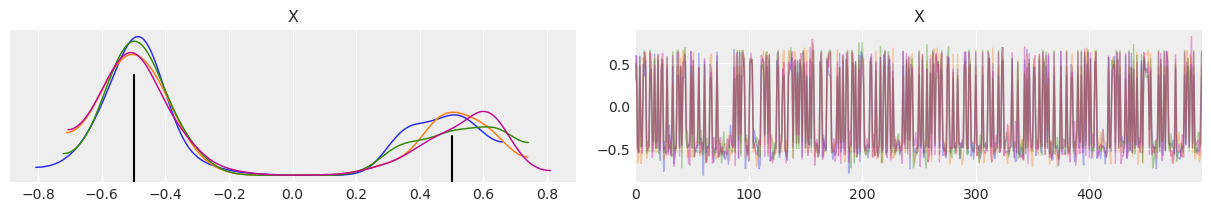

In [44]:
plt.figure()
ax = az.plot_trace(az_trace, compact=True)
for i in range(len(ax)):
    ax[i, 0].axvline(-0.5, 0, 0.7, color='k')
    ax[i, 0].axvline(0.5, 0, 0.3, color='k')
plt.show()

<Figure size 720x480 with 0 Axes>

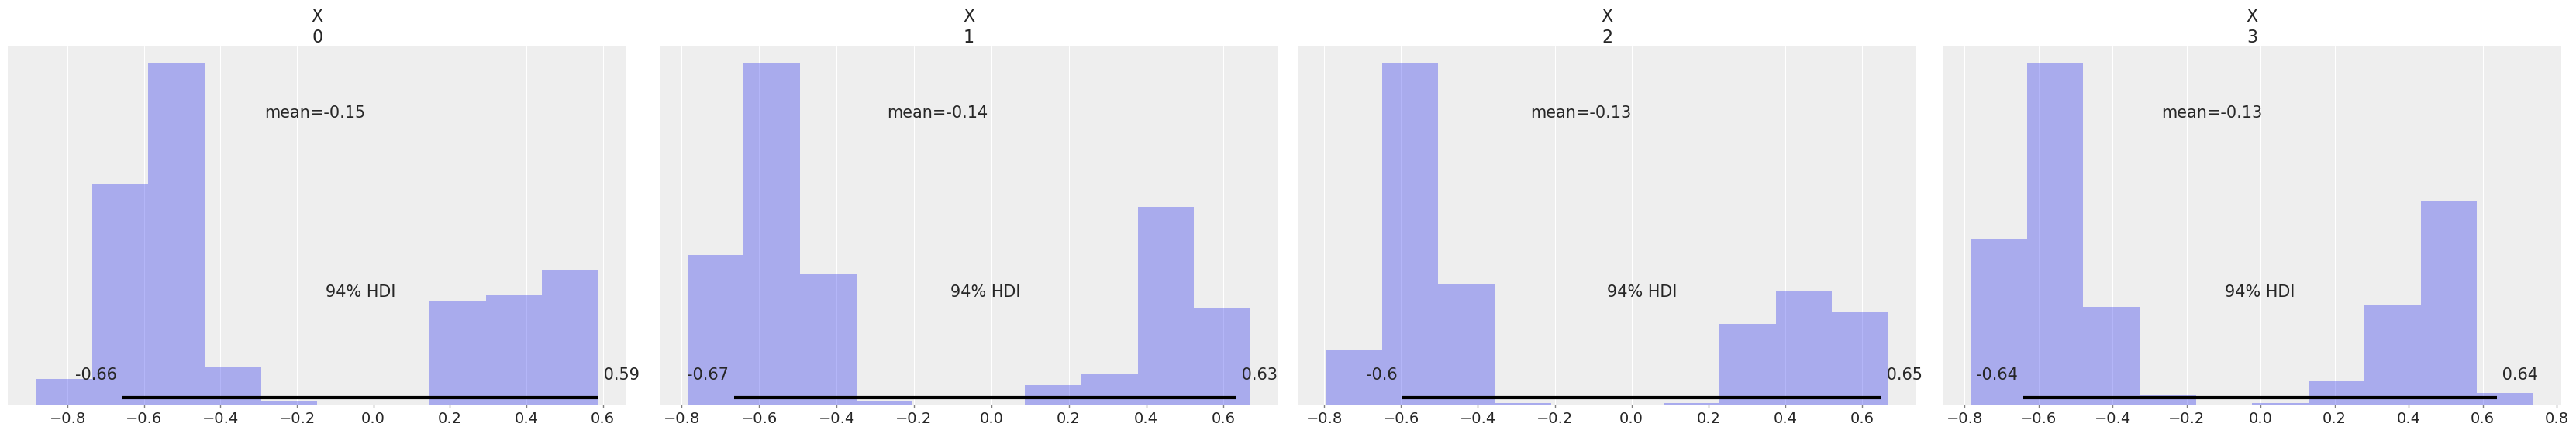

In [45]:
plt.figure()
az.plot_posterior(az_trace, kind='hist')
plt.show()

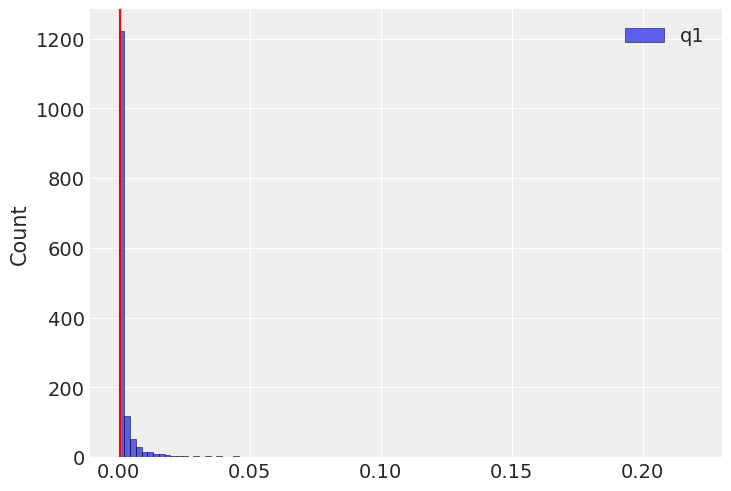

1500


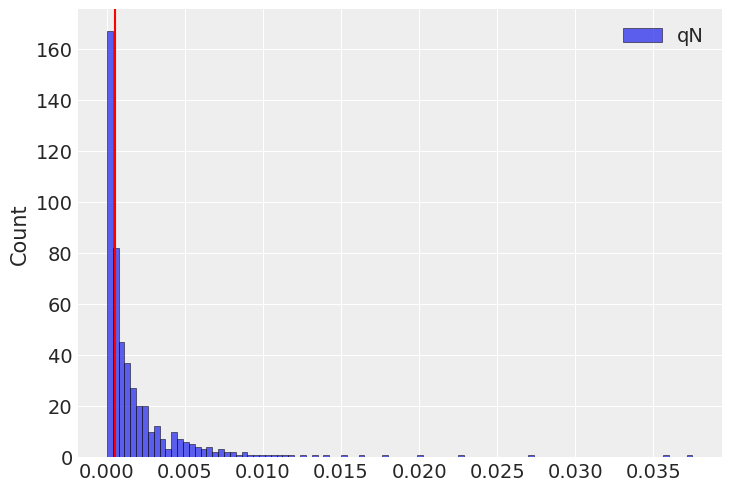

In [46]:
plt.figure()
sns.histplot(importance_weights[0][:2000], bins=100, label='q1')
plt.axvline(x=1/2000, color='r')
plt.legend(loc='upper right')
plt.show()

print(len(importance_weights[0]))

plt.figure()
sns.histplot(importance_weights[0][int(len(importance_weights[0]) - 2000):], bins=100, label='qN')
plt.axvline(x=1/2000, color='r')
plt.legend(loc='upper right')
plt.show()


Let's just check these results against those from SMC. 

In [47]:
with model:
    az_smc_trace = az.from_pymc3(smc_trace)

In [48]:
smc_evidence = np.exp(smc_trace.report.log_marginal_likelihood)
print(f'SMC calculated evidence: {smc_evidence}')
az_smc_summary = az.summary(az_smc_trace)
print(az_smc_summary)

SMC calculated evidence: [0.00177368 0.00413477]
       mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_mean  ess_sd  \
X[0] -0.171  0.478  -0.682    0.613      0.027    0.019     315.0   315.0   
X[1] -0.188  0.478  -0.676    0.618      0.026    0.019     328.0   328.0   
X[2] -0.178  0.476  -0.681    0.608      0.028    0.020     283.0   283.0   
X[3] -0.183  0.482  -0.705    0.607      0.029    0.021     270.0   270.0   

      ess_bulk  ess_tail  r_hat  
X[0]     446.0     455.0   1.01  
X[1]     431.0     427.0   1.00  
X[2]     292.0     496.0   1.01  
X[3]     293.0     463.0   1.01  


<Figure size 720x480 with 0 Axes>

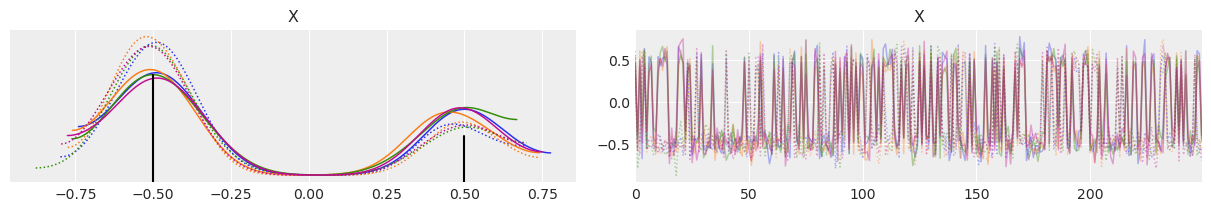

In [49]:
plt.figure()
ax = az.plot_trace(az_smc_trace, compact=True)
for i in range(len(ax)):
    ax[i, 0].axvline(-0.5, 0, 0.7, color='k')
    ax[i, 0].axvline(0.5, 0, 0.3, color='k')
plt.show()

<Figure size 720x480 with 0 Axes>

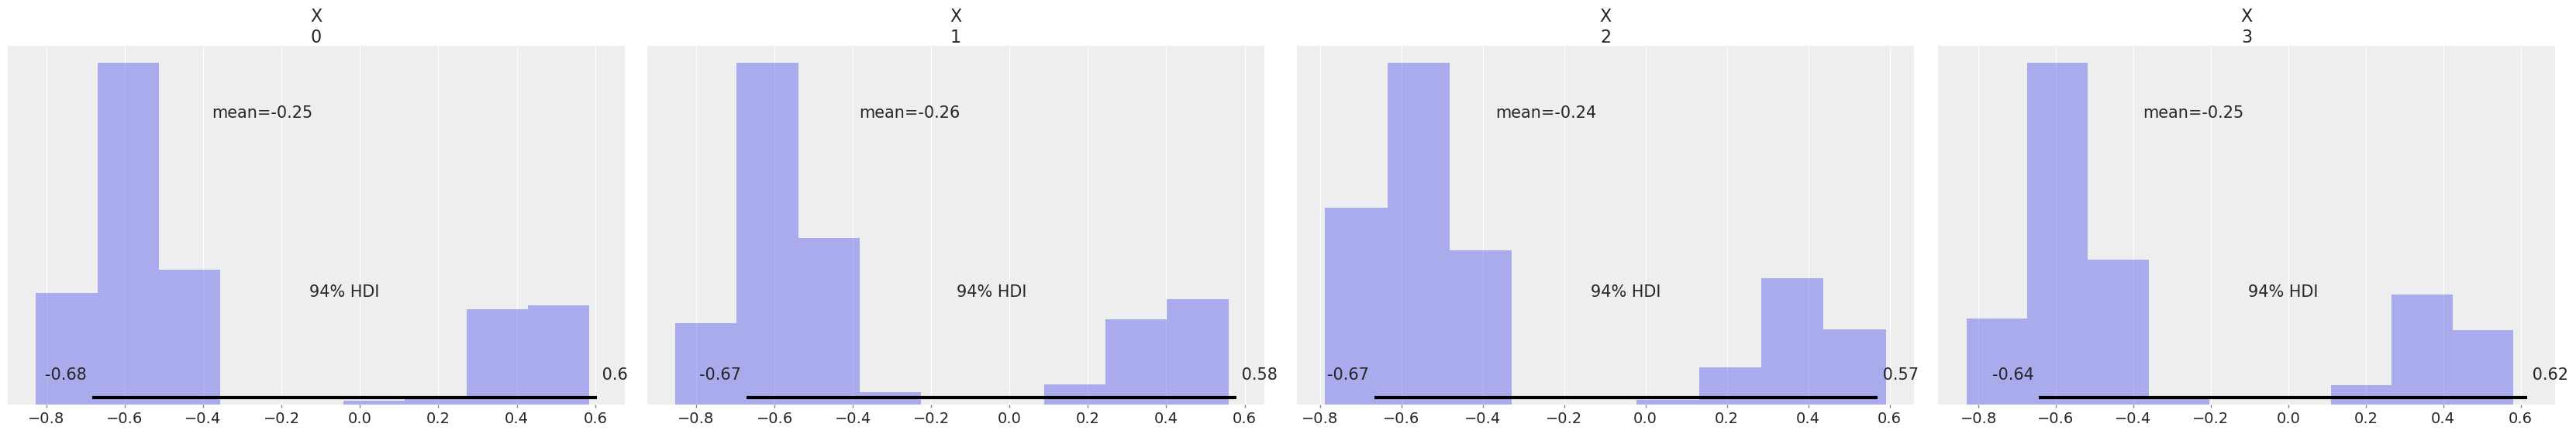

In [34]:
plt.figure()
az.plot_posterior(az_smc_trace, kind='hist')
plt.show()

Below I plot the X[0] posterior obtained from the NFMC and SMC runs. 

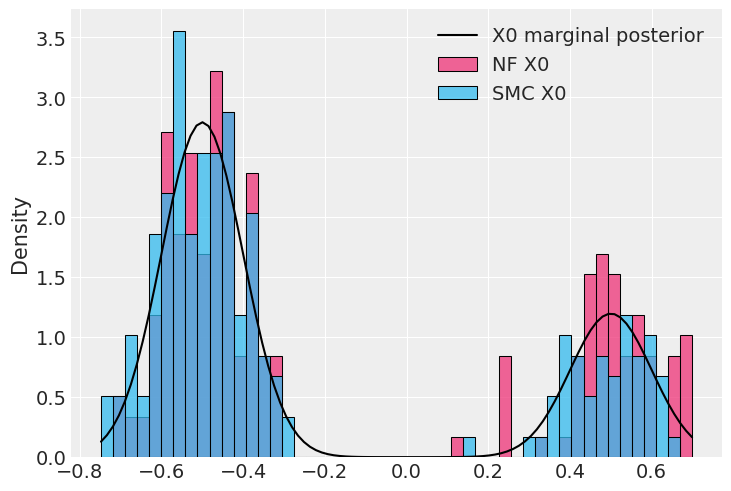

In [35]:
def marginal_two_gauss(x, mu1=0.5, mu2=-0.5, sigma=0.1):
    like1 = np.exp(-(x - mu1)**2 / (2 * sigma**2)) / np.sqrt(2 * np.pi * sigma**2)
    like2 = np.exp(-(x - mu2)**2 / (2 * sigma**2)) / np.sqrt(2 * np.pi * sigma**2)
    return w1 * like1 + w2 * like2

nf_df = az_trace.to_dataframe()
smc_df = az_smc_trace.to_dataframe()

nf_x0 = nf_df[('X[0]', 0)].to_numpy()
nf_x1 = nf_df[('X[1]', 1)].to_numpy()
nf_x2 = nf_df[('X[2]', 2)].to_numpy()
nf_x3 = nf_df[('X[3]', 3)].to_numpy()
smc_x0 = smc_df[('X[0]', 0)].to_numpy()
smc_x1 = smc_df[('X[1]', 1)].to_numpy()
smc_x2 = smc_df[('X[2]', 2)].to_numpy()
smc_x3 = smc_df[('X[3]', 3)].to_numpy()

x_vals = np.linspace(min(np.amin(nf_x0), np.amin(smc_x0)), max(np.amax(nf_x0), np.amax(smc_x0)), 100)
y_vals = marginal_two_gauss(x_vals)

bins = np.linspace(min(np.amin(nf_x0), np.amin(smc_x0)), max(np.amax(nf_x0), np.amax(smc_x0)), 50)
plt.figure()
sns.histplot(nf_x0, label='NF X0', bins=bins, stat='density', color='#EE3377')
sns.histplot(smc_x0, label='SMC X0', bins=bins, stat='density', color='#33BBEE')
plt.plot(x_vals, y_vals, color='k', label='X0 marginal posterior')
plt.legend(loc='upper right')
plt.show()

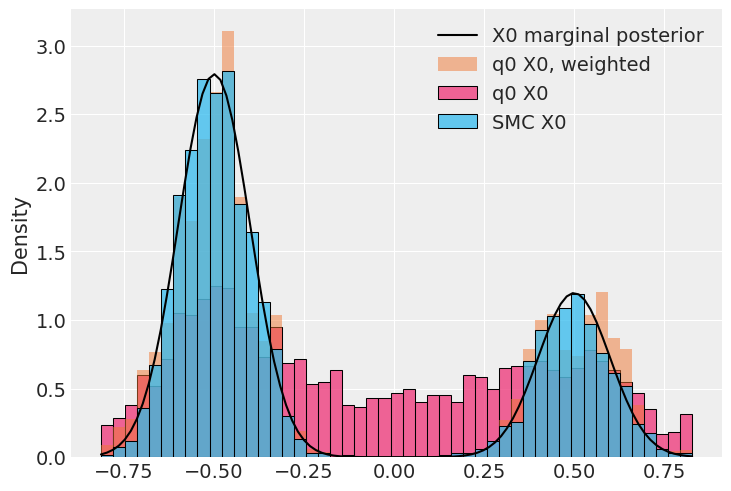

In [21]:
plt.figure()
sns.histplot(q0_samples[:,0], label='q0 X0', bins=bins, stat='density', color='#EE3377')
plt.hist(q0_samples[:,0], weights=q0_weights/np.sum(q0_weights), label='q0 X0, weighted', 
             bins=bins, density=True, color='#EE7733', alpha=0.5)
sns.histplot(smc_x0, label='SMC X0', bins=bins, stat='density', color='#33BBEE')
plt.plot(x_vals, y_vals, color='k', label='X0 marginal posterior')
plt.legend(loc='upper right')
plt.show()

In [19]:
rg_model = pm.Model()
x = np.arange(10)
y = 2 * x + 1 + np.random.normal(scale=0.1)

with rg_model:

    a = pm.Normal('a', mu=2, sigma=1)
    b = pm.Normal('b', mu=1, sigma=1)

    like = pm.Normal('like', mu=a*x+b, sigma=0.1, observed=y)
    
    nuts_trace = pm.sample(100)
    
    a_samples = nuts_trace.get_values('a')
    b_samples = nuts_trace.get_values('b')

init_samples = np.column_stack((b_samples, a_samples))


with rg_model:
    
    rg_trace = pm.sample_nfmc(200, init_method='full_rank', optim_iter=1000, nf_iter=1, chains=1,
                              frac_validate=0.2, alpha=(0,0), parallel=False, bw_factor=2.0,
                              k_trunc=0.25, pareto=True, iteration=5)
    rg_az_trace = az.from_pymc3(rg_trace)

/home/richard/pymc3_dev/pymc3/sampling.py:466: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  warnings.warn(
Only 100 samples in chain.
Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
INFO:pymc3:Sequential sampling (2 chains in 1 job)
NUTS: [b, a]
INFO:pymc3:NUTS: [b, a]


Sampling 2 chains for 1_000 tune and 100 draw iterations (2_000 + 200 draws total) took 5 seconds.
INFO:pymc3:Sampling 2 chains for 1_000 tune and 100 draw iterations (2_000 + 200 draws total) took 5 seconds.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
INFO:pymc3:The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
Initializing normalizing flow based sampling...
INFO:pymc3:Initializing normalizing flow based sampling...
Sampling 1 chain Cores available for optimization: 0
INFO:pymc3:Sampling 1 chain Cores available for optimization: 0


Initializing with full-rank EL2O approx family.



(2,)
MAP estimate = {'a': array(2.00007344), 'b': array(1.13466074)}


Stage:   1, Normalizing Constant Estimate: 13.538619564003882
INFO:pymc3:Stage:   1, Normalizing Constant Estimate: 13.538619564003882


Final EL2O mu = [[1.13466074 2.00007344]]
Final EL2O Sigma = [[ 0.00344236 -0.00054351]
 [-0.00054351  0.0001209 ]]
Fitting the first NF approx to the initial samples ...


KeyboardInterrupt: 

<Figure size 720x480 with 0 Axes>

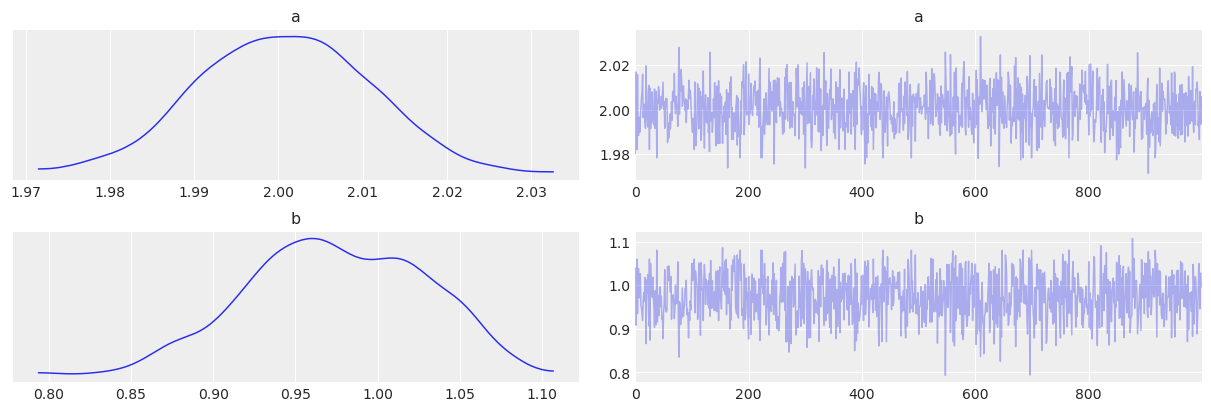

In [12]:
plt.figure()
ax = az.plot_trace(rg_az_trace)
plt.show()

/home/richard/anaconda3/envs/pymc3_dev/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


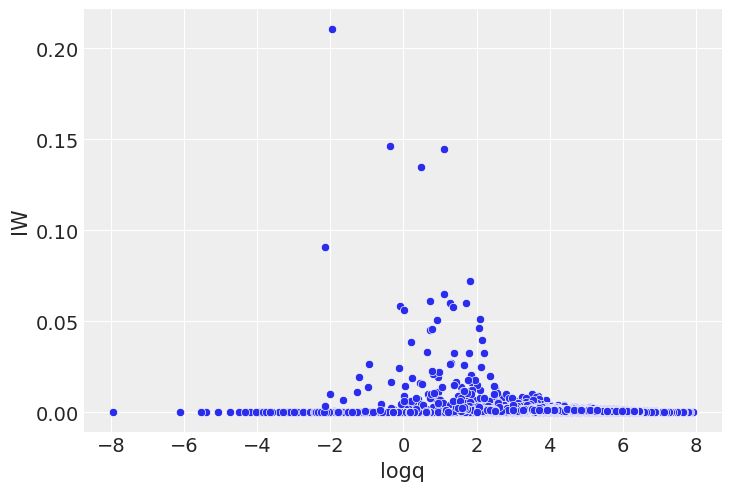

In [13]:
rg_logq = rg_trace.report.logq
rg_iw = rg_trace.report.importance_weights
plt.figure()
sns.scatterplot(rg_logq[0][2000:], rg_iw[0][2000:])
plt.xlabel('logq')
plt.ylabel('IW')
plt.show()

Let's look at what happens if we initialize with samples from a Gaussian distribution that is too narrow.

In [14]:
rg_df = az.summary(rg_az_trace)
init_samples = np.random.multivariate_normal(mean=np.array([rg_df['mean']['b'], rg_df['mean']['a']]), 
                                             cov=np.diagflat(np.array([rg_df['sd']['b']**2, rg_df['sd']['a']**2]))/4, 
                                             size=2000)
with rg_model:
    
    rg_narrow_trace = pm.sample_nfmc(2000, init_samples=init_samples, optim_iter=1000, nf_iter=10, chains=1,
                              frac_validate=0.2, alpha=(0.75,0.75), parallel=False, bw_factor=0.5,
                              k_trunc=0.25, pareto=False, norm_tol=1e-2)
    rg_narrow_az_trace = az.from_pymc3(rg_narrow_trace)

arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
Initializing normalizing flow based sampling...
INFO:pymc3:Initializing normalizing flow based sampling...
Sampling 1 chain Cores available for optimization: 0
INFO:pymc3:Sampling 1 chain Cores available for optimization: 0


Fitting the first NF approx to the initial samples ...


Stage:   1, Normalizing Constant Estimate: 305.00394559056457
INFO:pymc3:Stage:   1, Normalizing Constant Estimate: 305.00394559056457
Stage:   2, Normalizing Constant Estimate: 369.24962990443606
INFO:pymc3:Stage:   2, Normalizing Constant Estimate: 369.24962990443606
Stage:   3, Normalizing Constant Estimate: 351.2529318069559
INFO:pymc3:Stage:   3, Normalizing Constant Estimate: 351.2529318069559
Stage:   4, Normalizing Constant Estimate: 364.13500844965995
INFO:pymc3:Stage:   4, Normalizing Constant Estimate: 364.13500844965995
Stage:   5, Normalizing Constant Estimate: 354.2554826053604
INFO:pymc3:Stage:   5, Normalizing Constant Estimate: 354.2554826053604


Normalizing constant estimate has stabilised - ending NF fits.


<Figure size 720x480 with 0 Axes>

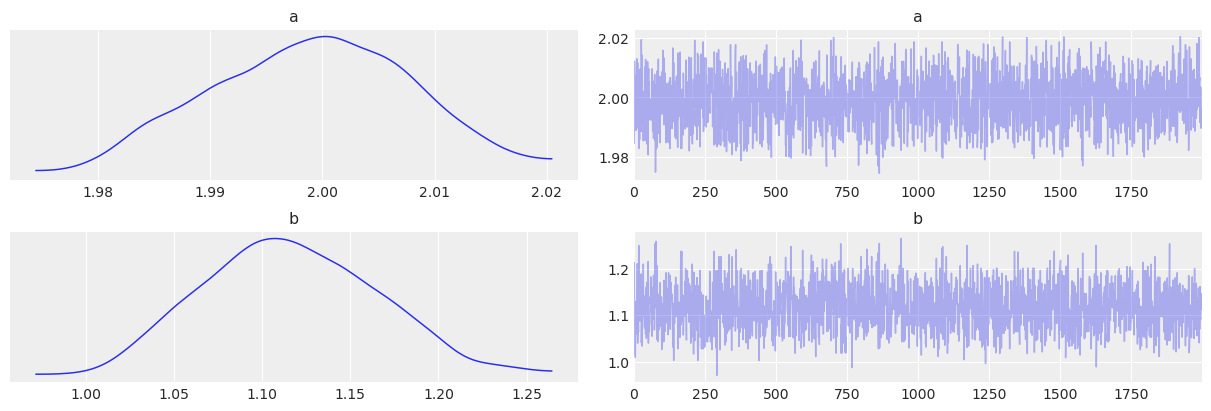

In [14]:
plt.figure()
ax = az.plot_trace(rg_narrow_az_trace)
plt.show()

/home/richard/anaconda3/envs/pymc3_dev/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


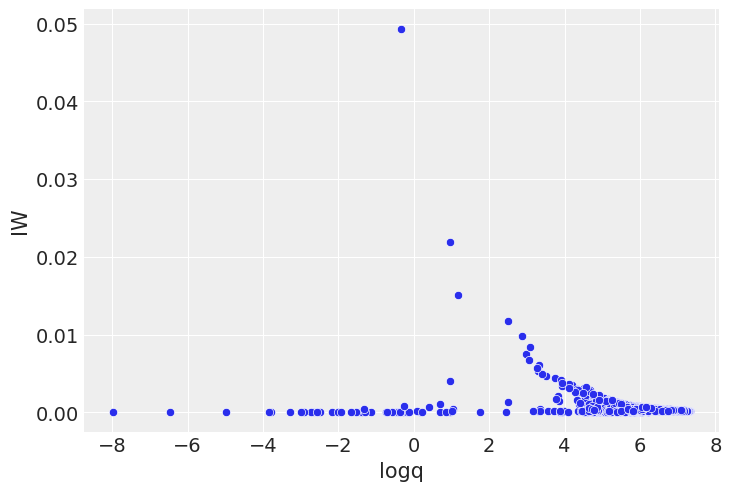

/home/richard/anaconda3/envs/pymc3_dev/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


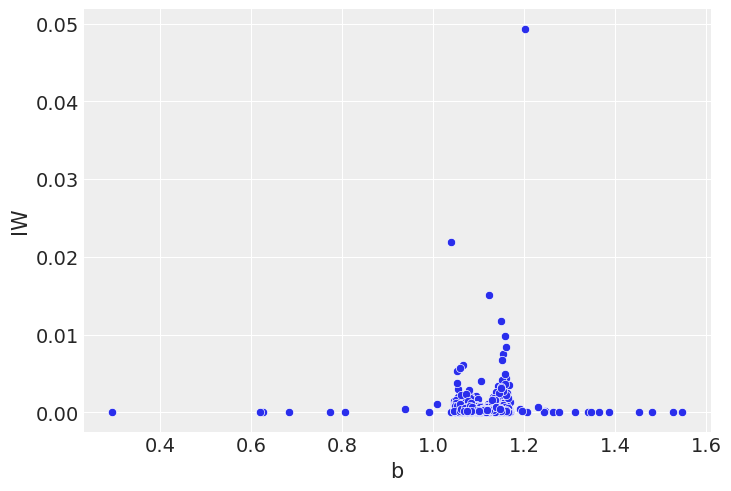

In [33]:
rg_narrow_logq = rg_narrow_trace.report.logq
rg_narrow_iw = rg_narrow_trace.report.importance_weights
rg_narrow_z = rg_narrow_trace.report.weighted_samples

i = 0
low = int(2000 * i)
high = int(2000 * (i + 1))

plt.figure()
sns.scatterplot(rg_narrow_logq[0][low:high], rg_narrow_iw[0][low:high])
plt.xlabel('logq')
plt.ylabel('IW')
plt.show()

plt.figure()
sns.scatterplot(rg_narrow_z[0][low:high, 0], rg_narrow_iw[0][low:high])
plt.xlabel('b')
plt.ylabel('IW')
plt.show()

In [17]:
rg_df = az.summary(rg_az_trace)
init_samples = np.random.multivariate_normal(mean=np.array([rg_df['mean']['b'], rg_df['mean']['a']]), 
                                             cov=np.diagflat(np.array([rg_df['sd']['b']**2, rg_df['sd']['a']**2]))/4, 
                                             size=2000)
with rg_model:
    
    rg_narrow_trace = pm.sample_nfmc(2000, init_samples=init_samples, optim_iter=1000, nf_iter=10, chains=1,
                              frac_validate=0.2, alpha=(0.9,0.9), parallel=False, bw_factor=0.5,
                              k_trunc=0.25, pareto=False, norm_tol=1e-2)
    rg_narrow_az_trace = az.from_pymc3(rg_narrow_trace)

arviz - WARNING - Shape validation failed: input_shape: (1, 2000), minimum_shape: (chains=2, draws=4)
Initializing normalizing flow based sampling...
Sampling 1 chain Cores available for optimization: 0


Fitting the first NF approx to the initial samples ...


Stage:   1, Normalizing Constant Estimate: 275.7350005795149
Stage:   2, Normalizing Constant Estimate: 311.55835020544464
Stage:   3, Normalizing Constant Estimate: 331.78546400780004
Stage:   4, Normalizing Constant Estimate: 372.8051967476202
Stage:   5, Normalizing Constant Estimate: 351.47200852014123
Stage:   6, Normalizing Constant Estimate: 356.6991573494204
Stage:   7, Normalizing Constant Estimate: 350.8495749861814


Normalizing constant estimate has stabilised - ending NF fits.


<Figure size 720x480 with 0 Axes>

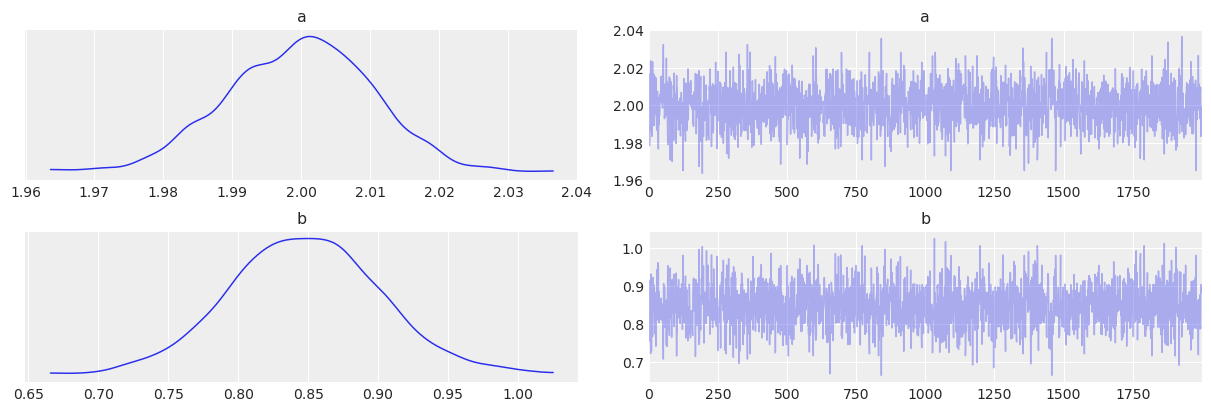

In [19]:
plt.figure()
ax = az.plot_trace(rg_narrow_az_trace)
plt.show()

In [20]:
rg_df = az.summary(rg_az_trace)
init_samples = np.random.multivariate_normal(mean=np.array([rg_df['mean']['b'], rg_df['mean']['a']]), 
                                             cov=np.diagflat(np.array([rg_df['sd']['b']**2, rg_df['sd']['a']**2]))/4, 
                                             size=2000)
with rg_model:
    
    rg_narrow_trace = pm.sample_nfmc(2000, init_samples=init_samples, optim_iter=1000, nf_iter=10, chains=1,
                              frac_validate=0.2, alpha=None, parallel=False, bw_factor=0.5,
                              k_trunc=0.25, pareto=False, norm_tol=1e-2)
    rg_narrow_az_trace = az.from_pymc3(rg_narrow_trace)

arviz - WARNING - Shape validation failed: input_shape: (1, 2000), minimum_shape: (chains=2, draws=4)
Initializing normalizing flow based sampling...
Sampling 1 chain Cores available for optimization: 0


Fitting the first NF approx to the initial samples ...


Stage:   1, Normalizing Constant Estimate: 253.38206256034275
Stage:   2, Normalizing Constant Estimate: 346.9854430935027
Stage:   3, Normalizing Constant Estimate: 335.59115261200725
Stage:   4, Normalizing Constant Estimate: 342.7714302577863
Stage:   5, Normalizing Constant Estimate: 350.1510114200305


Normalizing constant estimate has stabilised - ending NF fits.


<Figure size 720x480 with 0 Axes>

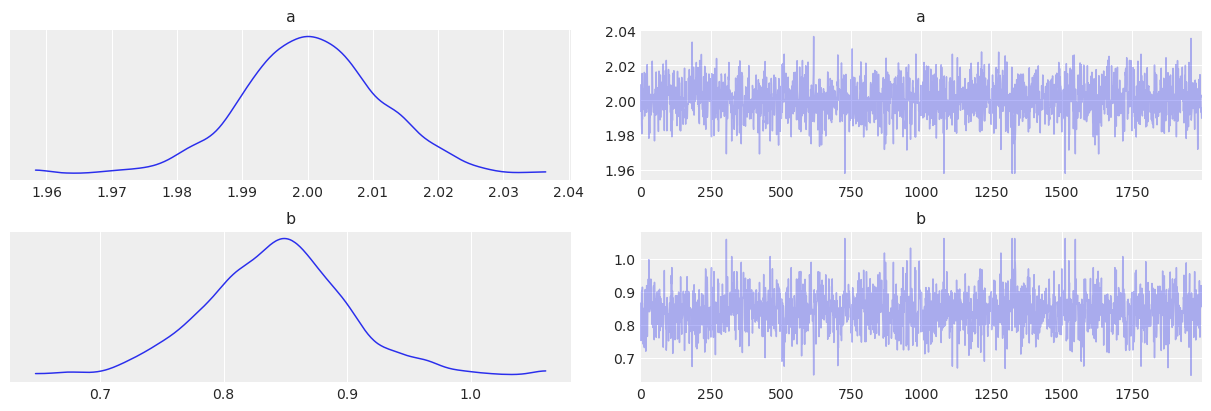

In [21]:
plt.figure()
ax = az.plot_trace(rg_narrow_az_trace)
plt.show()

In [23]:
rg_df = az.summary(rg_az_trace)
init_samples = np.random.multivariate_normal(mean=np.array([rg_df['mean']['b'], rg_df['mean']['a']]), 
                                             cov=np.diagflat(np.array([rg_df['sd']['b']**2, rg_df['sd']['a']**2]))/4, 
                                             size=2000)
with rg_model:
    
    rg_narrow_trace = pm.sample_nfmc(2000, init_samples=init_samples, optim_iter=1000, nf_iter=20, chains=1,
                              frac_validate=0.2, alpha=None, parallel=False, bw_factor=0.5,
                              k_trunc=0.25, pareto=False, norm_tol=1e-3)
    rg_narrow_az_trace = az.from_pymc3(rg_narrow_trace)

arviz - WARNING - Shape validation failed: input_shape: (1, 2000), minimum_shape: (chains=2, draws=4)
Initializing normalizing flow based sampling...
Sampling 1 chain Cores available for optimization: 0


Fitting the first NF approx to the initial samples ...


Stage:   1, Normalizing Constant Estimate: 212.46205023409388
Stage:   2, Normalizing Constant Estimate: 349.80423893560675
Stage:   3, Normalizing Constant Estimate: 287.01019928507685
Stage:   4, Normalizing Constant Estimate: 340.90547462499967
Stage:   5, Normalizing Constant Estimate: 358.10564692970223
Stage:   6, Normalizing Constant Estimate: 359.5749805369431
Stage:   7, Normalizing Constant Estimate: 346.0470843716024
Stage:   8, Normalizing Constant Estimate: 348.24150677029183
Stage:   9, Normalizing Constant Estimate: 351.83733776058597
Stage:  10, Normalizing Constant Estimate: 354.4637527885397
Stage:  11, Normalizing Constant Estimate: 348.08432721226797
Stage:  12, Normalizing Constant Estimate: 350.02748878720644
Stage:  13, Normalizing Constant Estimate: 351.1416602862509
Stage:  14, Normalizing Constant Estimate: 349.1104855221302


Normalizing constant estimate has stabilised - ending NF fits.


<Figure size 720x480 with 0 Axes>

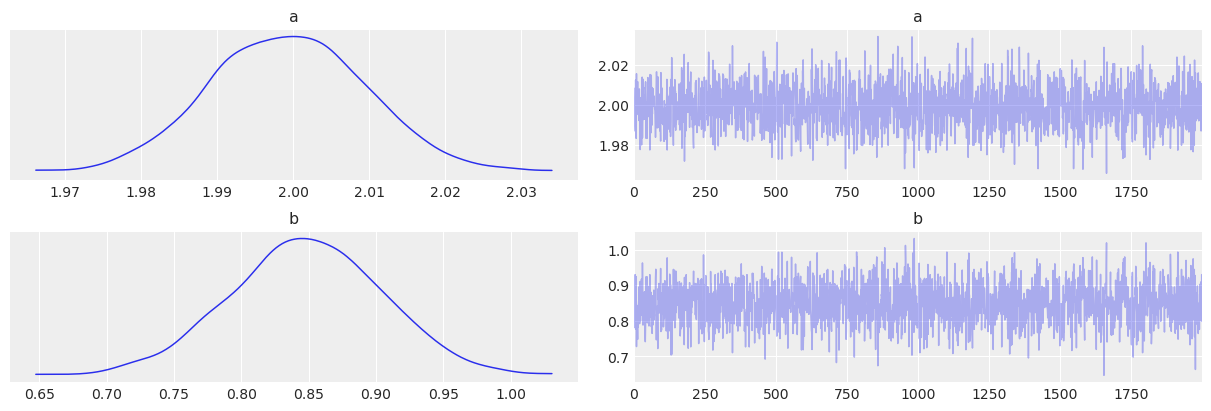

In [24]:
plt.figure()
ax = az.plot_trace(rg_narrow_az_trace)
plt.show()

Test initializing with full-rank EL2O

In [9]:
with rg_model:
    
    el2o_trace = pm.sample_nfmc(2000, init_method='full_rank', optim_iter=1000, nf_iter=20, chains=1,
                              frac_validate=0.2, alpha=(0.75, 0.75), parallel=False, bw_factor=0.5,
                              k_trunc=0.25, pareto=False, norm_tol=1e-2, iteration=20)
    el2o_az_trace = az.from_pymc3(el2o_trace)

Initializing normalizing flow based sampling...
INFO:pymc3:Initializing normalizing flow based sampling...
Sampling 1 chain Cores available for optimization: 0
INFO:pymc3:Sampling 1 chain Cores available for optimization: 0


Initializing with full-rank EL2O approx family.



MAP estimate = {'a': array(1.99989183), 'b': array(0.80166993)}
Final EL2O mu = [[0.80166993 1.99989183]]
Final EL2O Sigma = [[ 0.00344236 -0.00054351]
 [-0.00054351  0.0001209 ]]
Fitting the first NF approx to the initial samples ...


Stage:   1, Normalizing Constant Estimate: 347.09000897519724
INFO:pymc3:Stage:   1, Normalizing Constant Estimate: 347.09000897519724


Normalizing constant estimate has stabilised - ending NF fits.


<Figure size 720x480 with 0 Axes>

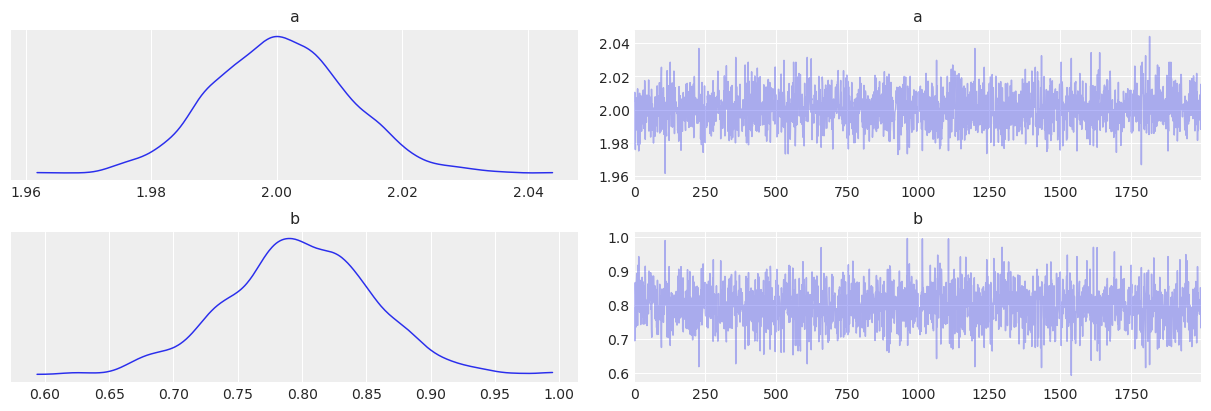

In [10]:
plt.figure()
ax = az.plot_trace(el2o_az_trace)
plt.show()

In [29]:
with rg_model:
    
    lbfgs_trace = pm.sample_nfmc(500, init_method='lbfgs', optim_iter=1000, nf_iter=20, chains=1,
                              frac_validate=0.2, alpha=(0, 0), parallel=False, bw_factor=2,
                              k_trunc=0.25, pareto=False, norm_tol=1e-2, iteration=20)
    lbfgs_az_trace = az.from_pymc3(lbfgs_trace)

Initializing normalizing flow based sampling...
Sampling 1 chain Cores available for optimization: 0


Using L-BFGS optimization and Hessian to initialize.



LBFGS hess = [[ 0.00344236 -0.00054351]
 [-0.00054351  0.0001209 ]]
Autodiff hess = [[ 0.00344236 -0.00054351]
 [-0.00054351  0.0001209 ]]
Fitting the first NF approx to the initial samples ...


Stage:   1, Normalizing Constant Estimate: 381.23140496613155
Stage:   2, Normalizing Constant Estimate: 353.6019726516262
Stage:   3, Normalizing Constant Estimate: 360.69245036200573
Stage:   4, Normalizing Constant Estimate: 351.73672431910427
Stage:   5, Normalizing Constant Estimate: 360.3840962891831
Stage:   6, Normalizing Constant Estimate: 353.3107982582024
Stage:   7, Normalizing Constant Estimate: 415.01598886672673
Stage:   8, Normalizing Constant Estimate: 341.9711159119934
Stage:   9, Normalizing Constant Estimate: 347.7599608985303
Stage:  10, Normalizing Constant Estimate: 378.734393199955
Stage:  11, Normalizing Constant Estimate: 345.86243021701694
Stage:  12, Normalizing Constant Estimate: 351.286465607817
Stage:  13, Normalizing Constant Estimate: 360.07169408020656


Normalizing constant estimate has stabilised - ending NF fits.


<Figure size 720x480 with 0 Axes>

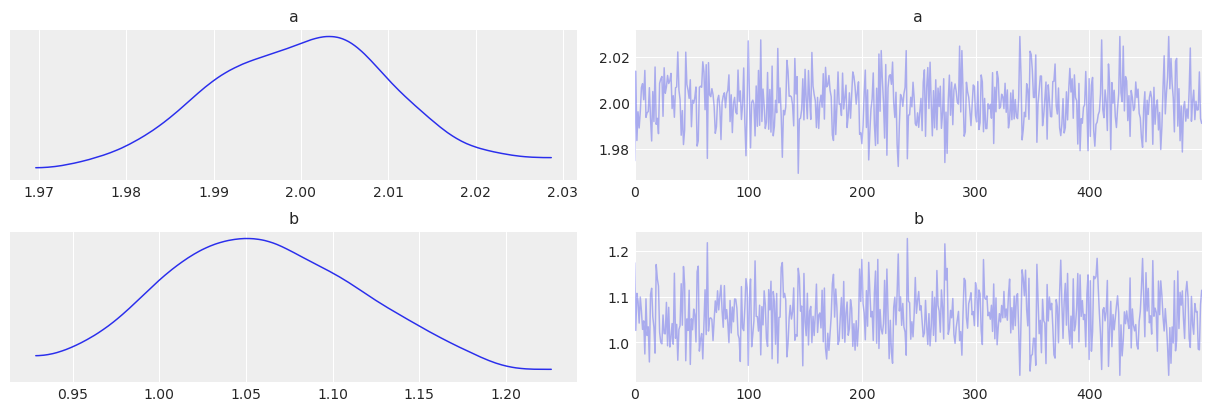

In [30]:
plt.figure()
ax = az.plot_trace(lbfgs_az_trace)
plt.show()

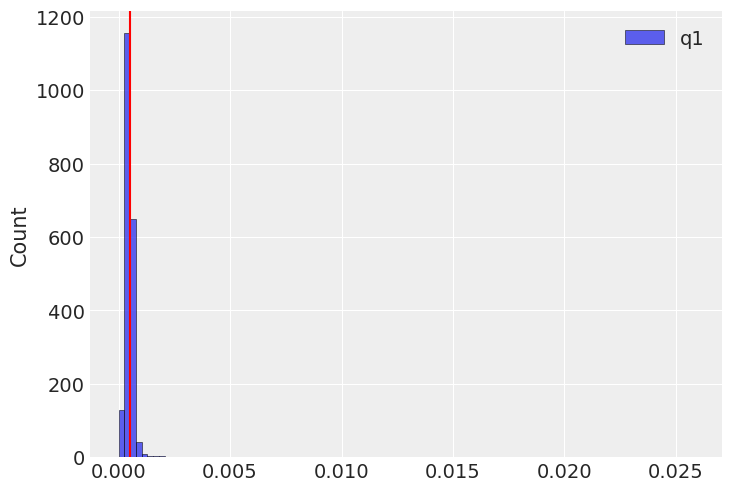

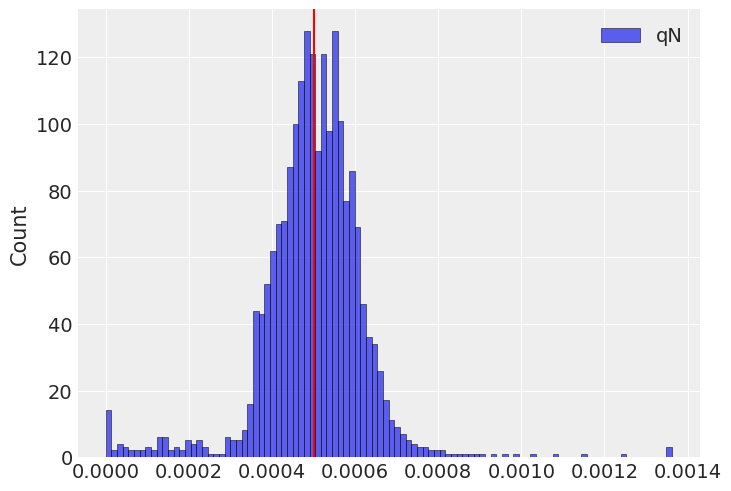

In [8]:
rg_importance_weights = rg_trace.report.importance_weights

plt.figure()
sns.histplot(rg_importance_weights[0][:2000], bins=100, label='q1')
plt.axvline(x=1/2000, color='r')
plt.legend(loc='upper right')
plt.show()


plt.figure()
sns.histplot(rg_importance_weights[0][int(len(rg_importance_weights[0]) - 2000):], bins=100, label='qN')
plt.axvline(x=1/2000, color='r')
plt.legend(loc='upper right')
plt.show()


In [30]:
with rg_model:
    nuts_az_trace = az.from_pymc3(nuts_trace)

<Figure size 720x480 with 0 Axes>

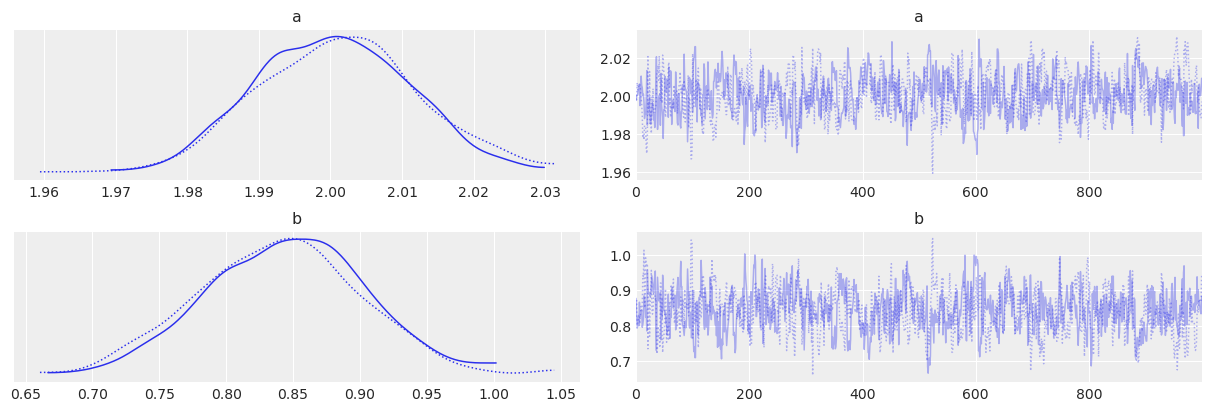

In [31]:
plt.figure()
ax = az.plot_trace(nuts_az_trace)
plt.show()

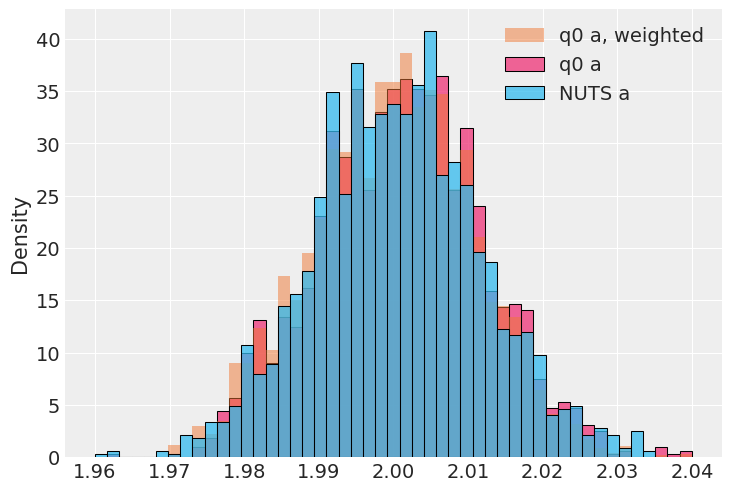

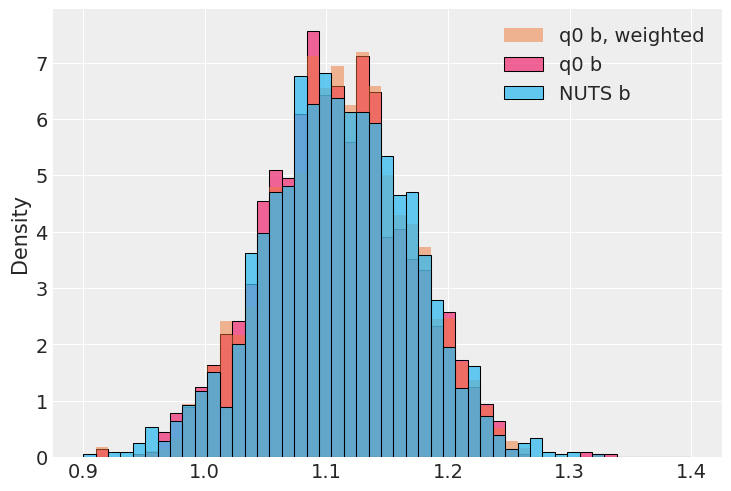

In [22]:
rg_weighted_samples = rg_trace.report.weighted_samples[0]
rg_q0_samples = rg_weighted_samples[:2000, ...]
rg_importance_weights = rg_trace.report.importance_weights
rg_q0_weights = rg_importance_weights[0][:2000]

bins = np.linspace(1.96, 2.04, 50)
plt.figure()
sns.histplot(rg_q0_samples[:,1], label='q0 a', bins=bins, stat='density', color='#EE3377')
plt.hist(rg_q0_samples[:,1], weights=rg_q0_weights/np.sum(rg_q0_weights), label='q0 a, weighted', 
             bins=bins, density=True, color='#EE7733', alpha=0.5)
sns.histplot(a_samples, label='NUTS a', bins=bins, stat='density', color='#33BBEE')
plt.legend(loc='upper right')
plt.show()

bins = np.linspace(0.9, 1.4, 50)
plt.figure()
sns.histplot(rg_q0_samples[:,0], label='q0 b', bins=bins, stat='density', color='#EE3377')
plt.hist(rg_q0_samples[:,0], weights=rg_q0_weights/np.sum(rg_q0_weights), label='q0 b, weighted', 
             bins=bins, density=True, color='#EE7733', alpha=0.5)
sns.histplot(b_samples, label='NUTS b', bins=bins, stat='density', color='#33BBEE')
plt.legend(loc='upper right')
plt.show()

In [52]:
def z_integrand(a, b):
    p_a = np.exp(-(a - 2)**2 / 2) / np.sqrt(2 * np.pi)
    p_b = np.exp(-(b - 1)**2 / 2) / np.sqrt(2 * np.pi)
    l = np.prod(np.exp(-(y - a * x - b)**2 / (2 * 0.1**2)) / np.sqrt(2 * np.pi * 0.1**2))
    return l * p_a * p_b

from scipy import integrate
result = integrate.dblquad(z_integrand, 0.8, 1.2, 1.96, 2.04)
print(result)

(354.47752481652395, 1.4508249154328995e-05)


Quick ring density test ...

In [4]:
a = 2
b = 1
n = 4

def ring(X):

    return -((X[-1]**2 + X[0]**2 - a)**2 / b)**2 - tt.sum(((X[:-1]**2 + X[1:]**2 - a)**2 / b)**2)
    
with pm.Model() as model:
    
    X = pm.Uniform(
        "X",
        shape=n,
        lower=-5.0,
        upper=5.0,
        testval=1.0,
    )
    
    llk = pm.Potential("llk", ring(X))
    
    
    ring_trace = pm.sample_nfmc(2000, init_method='full_rank', optim_iter=1000, nf_iter=40, chains=1, 
                                frac_validate=0.2, alpha=(0,0), parallel=False, ftol=1.0e-12, 
                                NBfirstlayer=True, bw_factor=2.0, k_trunc=0.25, pareto=True, iteration=5)
    az_ring_trace = az.from_pymc3(ring_trace)

Initializing normalizing flow based sampling...
INFO:pymc3:Initializing normalizing flow based sampling...
Sampling 1 chain Cores available for optimization: 0
INFO:pymc3:Sampling 1 chain Cores available for optimization: 0


Initializing with full-rank EL2O approx family.



(4,)
MAP estimate = {'X_interval__': array([0.40546511, 0.40546511, 0.40546511, 0.40546511]), 'X': array([1., 1., 1., 1.])}


/home/richard/pymc3_dev/pymc3/nfmc/nfmc.py:324: RuntimeWarning: covariance is not positive-semidefinite.
  self.prior_samples = np.random.multivariate_normal(self.mu_k.squeeze(), self.Sigma_k, size=self.draws)
Stage:   1, Normalizing Constant Estimate: 0.0028523147834972414
INFO:pymc3:Stage:   1, Normalizing Constant Estimate: 0.0028523147834972414


Final EL2O mu = [[ 0.81573903  0.66595838 -0.20011764  0.00307835]]
Final EL2O Sigma = [[ 8.16330175e-06 -5.94476090e-07 -1.17556247e-06  4.22584755e-07]
 [-5.94476090e-07  6.63303676e-06  6.73218108e-07 -1.55749315e-06]
 [-1.17556247e-06  6.73218108e-07 -1.31380742e-06  3.79249963e-06]
 [ 4.22584755e-07 -1.55749315e-06  3.79249963e-06 -6.36774905e-07]]
Fitting the first NF approx to the initial samples ...


Stage:   2, Normalizing Constant Estimate: 0.0013984152716476487
INFO:pymc3:Stage:   2, Normalizing Constant Estimate: 0.0013984152716476487
Stage:   3, Normalizing Constant Estimate: 0.001139424191108199
INFO:pymc3:Stage:   3, Normalizing Constant Estimate: 0.001139424191108199
Stage:   4, Normalizing Constant Estimate: 0.0012021396937576172
INFO:pymc3:Stage:   4, Normalizing Constant Estimate: 0.0012021396937576172
Stage:   5, Normalizing Constant Estimate: 0.0011409894728956712
INFO:pymc3:Stage:   5, Normalizing Constant Estimate: 0.0011409894728956712
Stage:   6, Normalizing Constant Estimate: 0.0012771354385851174
INFO:pymc3:Stage:   6, Normalizing Constant Estimate: 0.0012771354385851174
Stage:   7, Normalizing Constant Estimate: 0.0012549143470823498
INFO:pymc3:Stage:   7, Normalizing Constant Estimate: 0.0012549143470823498
Stage:   8, Normalizing Constant Estimate: 0.001132889037617126
INFO:pymc3:Stage:   8, Normalizing Constant Estimate: 0.001132889037617126
Stage:   9, Norma

Normalizing constant estimate has stabilised - ending NF fits.


<Figure size 720x480 with 0 Axes>

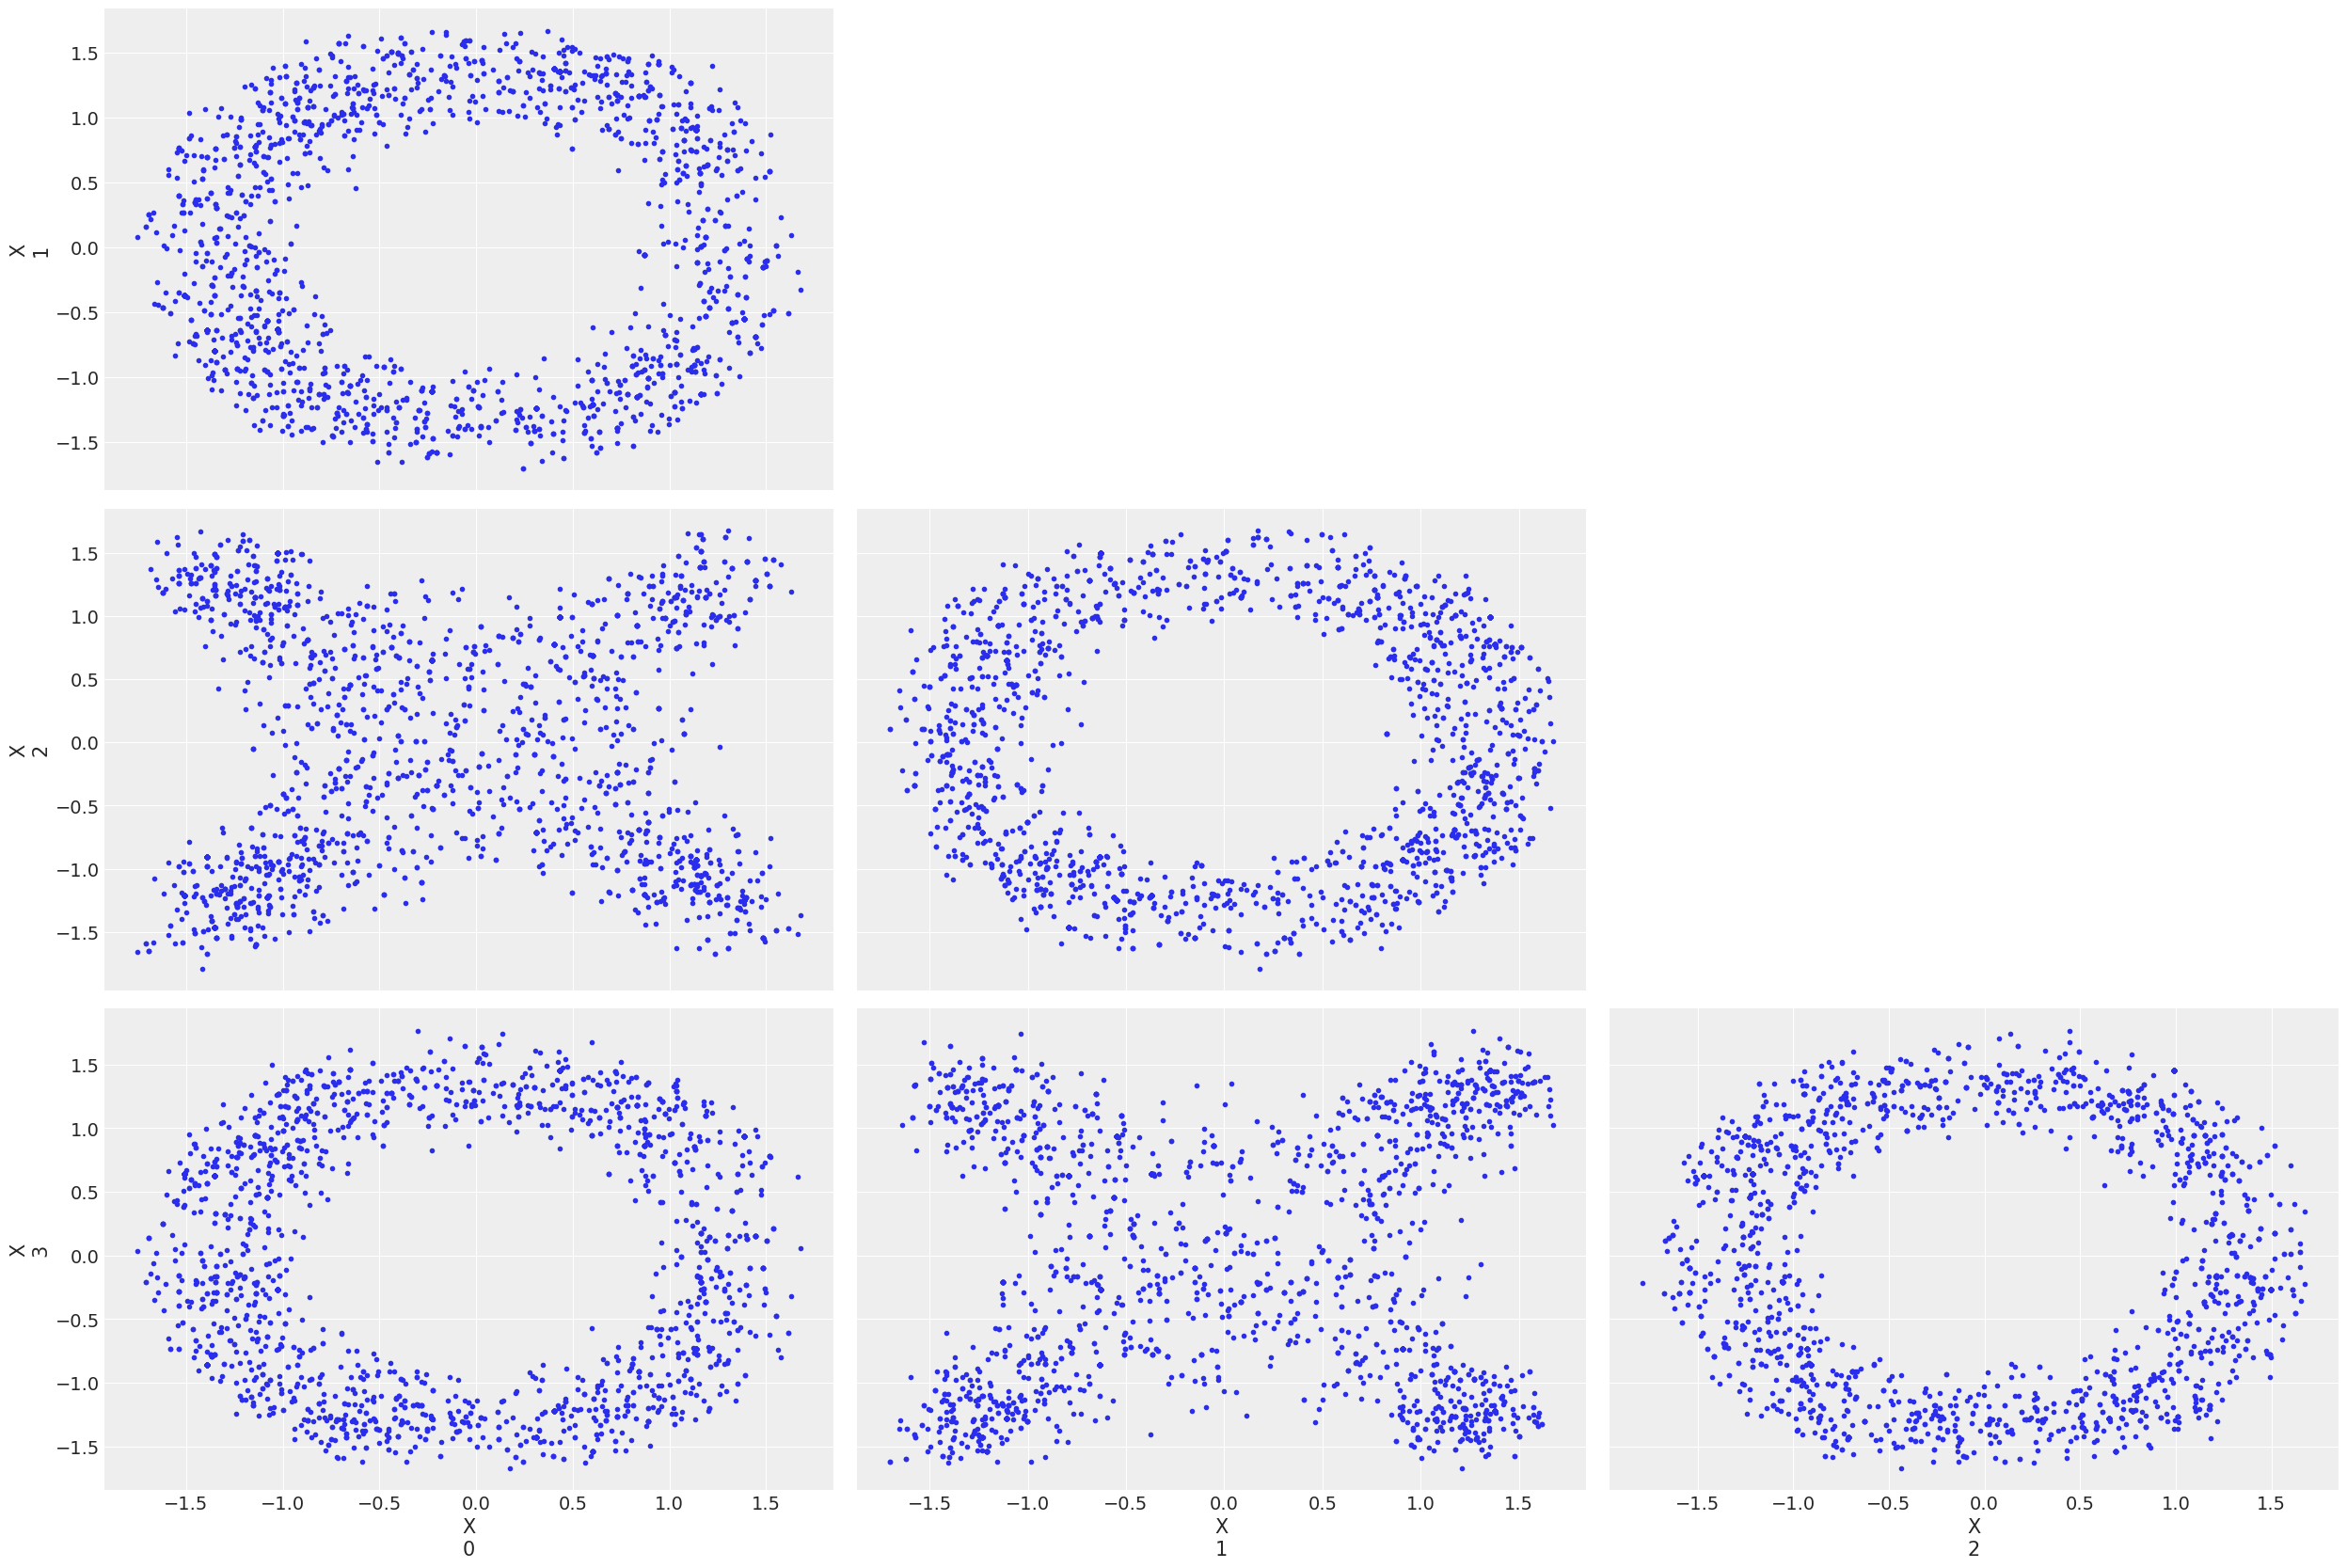

<Figure size 720x480 with 0 Axes>

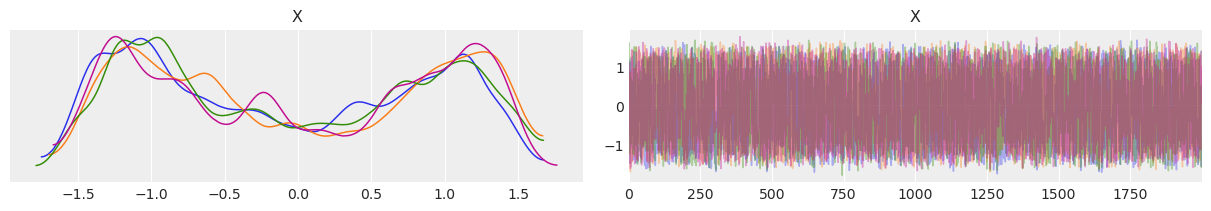

In [5]:
plt.figure()
az.plot_pair(az_ring_trace)
plt.show()

plt.figure()
az.plot_trace(az_ring_trace)
plt.show()

Hierarchical Radon Model ....

In [20]:
data = pd.read_csv(pm.get_data("radon.csv"))
data["log_radon"] = data["log_radon"].astype(theano.config.floatX)
county_names = data.county.unique()
county_idx = data.county_code.values

n_counties = len(data.county.unique())

In [21]:
with pm.Model() as hierarchical_model:
    # Hyperpriors for group nodes
    mu_a = pm.Normal("mu_a", mu=0.0, sigma=100)
    sigma_a = pm.HalfNormal("sigma_a", 5.0)
    mu_b = pm.Normal("mu_b", mu=0.0, sigma=100)
    sigma_b = pm.HalfNormal("sigma_b", 5.0)

    # Intercept for each county, distributed around group mean mu_a
    # Above we just set mu and sd to a fixed value while here we
    # plug in a common group distribution for all a and b (which are
    # vectors of length n_counties).
    a = pm.Normal("a", mu=mu_a, sigma=sigma_a, shape=n_counties)
    # Intercept for each county, distributed around group mean mu_a
    b = pm.Normal("b", mu=mu_b, sigma=sigma_b, shape=n_counties)

    # Model error
    eps = pm.HalfCauchy("eps", 5.0)

    radon_est = a[county_idx] + b[county_idx] * data.floor.values

    # Data likelihood
    radon_like = pm.Normal("radon_like", mu=radon_est, sigma=eps, observed=data.log_radon)

First, let's sample the posterior using NUTS.

In [22]:
with hierarchical_model:
    hierarchical_trace = pm.sample(2000, tune=2000, target_accept=0.9)
    hierarchical_az_trace = az.from_pymc3(hierarchical_trace)

/home/richard/pymc3_dev/pymc3/sampling.py:466: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  warnings.warn(
Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
INFO:pymc3:Sequential sampling (2 chains in 1 job)
NUTS: [eps, b, a, sigma_b, mu_b, sigma_a, mu_a]
INFO:pymc3:NUTS: [eps, b, a, sigma_b, mu_b, sigma_a, mu_a]


Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 115 seconds.
INFO:pymc3:Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 115 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 33 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 33 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.
ERROR:pymc3:The estimated number of effective samples is smaller than 200 for some parameters.


<Figure size 720x480 with 0 Axes>

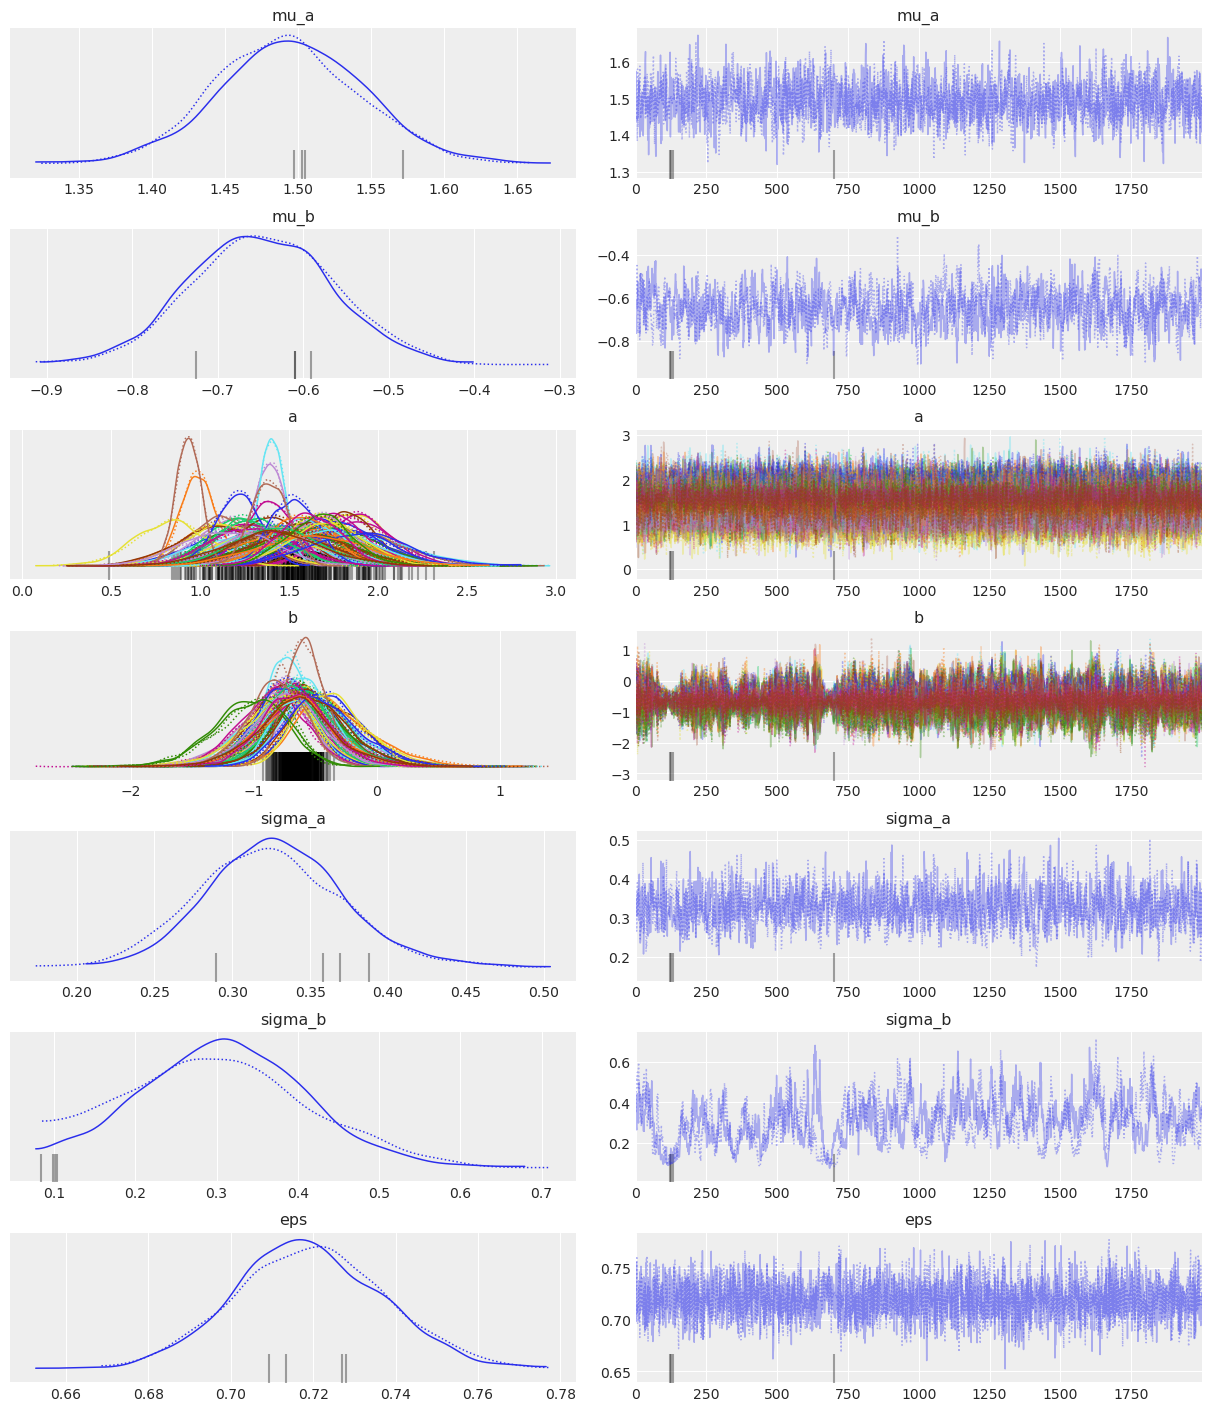

In [43]:
plt.figure()
ax = az.plot_trace(hierarchical_az_trace)
plt.show()

Now let's look at using NFMC.

In [44]:
with hierarchical_model:
    hierarchical_nf_trace = pm.sample_nfmc(500, optim_iter=1000, nf_iter=20, chains=1,
                                           frac_validate=0.2, alpha=(0.5,0.5), parallel=False)
    hierarchical_az_nf_trace = az.from_pymc3(hierarchical_nf_trace)

Initializing normalizing flow based sampling...
Sampling 1 chain Cores available for optimization: 0


Running initial optimization ...
Fitting the first NF approx to the prior optimized samples ...


KeyboardInterrupt: 